# ColdFusion
### GPR-LIDAR-FUSION
7/12/22

Query the SnowEx database to extract ground based snow depth measurements, snow pit density, GPR tracks, and Lidar point clounds where there is spatial and temporal overlap in a defined area.

Use the lidar snow depth measurements to inform the GPR density estimate to get SWE.

Test these density/SWE estimates against snowpit values

In [2]:
# Imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

import datetime
from sqlalchemy import inspect
from sqlalchemy.sql import func
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc

# Imports for Lidar raster
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

### Define Constants

In [3]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

# Define Dates
date1 = datetime.date(2020,1,29)
date2 = datetime.date(2020,2,6)

### Magnaprobe Data

In [4]:
# Instrument name 
site_name = "Grand Mesa"
instrument = "magnaprobe" 

# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box 
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date >= date1)
query_mp = query_mp.filter(PointData.date <= date2)

# Execute the query and convert to geopandas in one handy function
df_mp = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp.index)} records returned!')

session.close()

16556 records returned!


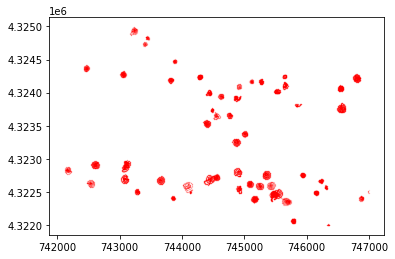

In [5]:
# Plot sites
plt.scatter(df_mp['easting'], df_mp['northing'], alpha = 0.3, s = 0.05, c = 'red')

# View dataframe 
# df_mp = df_mp.sort_values(by = ['date'])
# print(df_mp.head())

### Snow Pit measurements

In [6]:
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                      LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= date1)
query_sp = query_sp.filter(LayerData.date <= date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp = query_to_pandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

/tmp/ipykernel_89/3061429306.py:19: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  count_meas = query_sp.count()
/tmp/ipykernel_89/3061429306.py:19: SAWarning: Class ST_Within will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will d

1292  Snowpit density measurements returned!

70  Snowpit density locations returned!



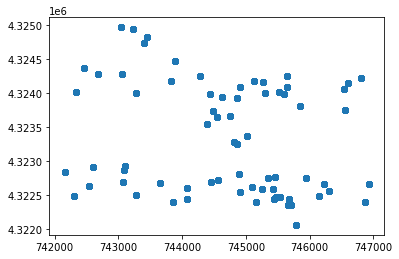

In [7]:
# Plot sites
plt.scatter(df_sp['easting'], df_sp['northing'])

In [17]:
# Average Snowpit density measurements
# Request the average (avg) of Layer data casted as a float. We have to cast to a float in the layer table because all main values are stored as a string to
# ...accommodate the hand hardness.
print(df_sp.columns)
df_sp['value'] = df_sp['value'].astype(float)
avgrho_sp = df_sp[['easting', 'northing', 'date', 'value', 'pit_id']]
avgrho_sp = df_sp.groupby(by = ['pit_id']).mean()
print(avgrho_sp.head())

Index(['geom', 'easting', 'northing', 'date', 'value', 'pit_id', 'type',
       'instrument'],
      dtype='object')
                    easting   northing       value
pit_id                                            
COGM1N20_20200205  743281.0  4324005.0  230.750000
COGM1S13_20200205  743277.0  4322508.0  320.312500
COGM1S8_20200201   742607.0  4322917.0  261.023810
COGM2C33_20200130  745787.0  4322066.0  278.823529
COGM2N12_20200131  742466.0  4324372.0  263.938596


### GPR Data

In [10]:
# Get the GPR Dates

# Start the session
engine, session = get_db(db_name)

# Define the GPR instrument identifier
bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

# Query the Pointdata to isolate by GPR instrument
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

# convert to pandas dataframe  
df = query_to_pandas(query, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
GPR_dates = sorted(df['date'].unique())

# Print the given dates
print(GPR_dates)

session.close()

[datetime.date(2020, 1, 28), datetime.date(2020, 1, 29), datetime.date(2020, 2, 4), datetime.date(2020, 2, 6), datetime.date(2020, 2, 7), datetime.date(2020, 2, 8), datetime.date(2020, 2, 9)]


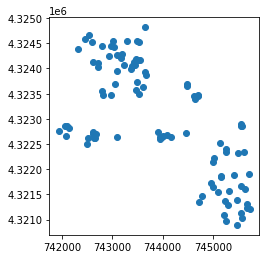

In [11]:
# Start the session
engine, session = get_db(db_name)

# Limit the size of the GPR data for initial processing and plot
query = session.query(PointData)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
query = query.distinct().order_by(func.random()).limit(100) #all()

bsu_gpr_sample = query_to_geopandas(query, engine)

bsu_gpr_sample.plot()

session.close()

### Get the Distance of snowPit to GPR

### Lidar Raster (In-Progress)

In [12]:
# Start the session
engine, session = get_db(db_name)

query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

session.close()

[('meters',)]
